<a href="https://colab.research.google.com/github/vignesh-codes/ECE9063-Assignment-2/blob/main/rnn_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
# Load the dataset
df = pd.read_csv('train.csv')

# Filter data for store 1
df = df[df['store'] == 1]

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Extract useful features from the date
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Add lag features
df['lag_1'] = df['sales'].shift(1)  # Previous day's sales
df['lag_7'] = df['sales'].shift(7)  # Previous week's sales
df['lag_365'] = df['sales'].shift(365)  # Previous year's sales (seasonality)

# Add rolling mean features
df['rolling_mean_7'] = df['sales'].rolling(window=7).mean()
df['rolling_mean_30'] = df['sales'].rolling(window=30).mean()

# Drop NaN rows created by lag and rolling features
df = df.dropna()


In [3]:
# One-hot encode categorical features
df = pd.get_dummies(df, columns=['store', 'item'], drop_first=True)

# Create additional time-based features
df['day_of_week'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['season'] = df['date'].dt.month % 12 // 3 + 1

# Add additional lag features
df['lag_30'] = df['sales'].shift(30)
df['lag_60'] = df['sales'].shift(60)

# Add rolling statistics
df['rolling_std_7'] = df['sales'].rolling(window=7).std()
df['rolling_median_7'] = df['sales'].rolling(window=7).median()

# Drop NaN rows created by lag and rolling features
df = df.dropna()

In [4]:
# Define features (X) and target (y)
X = df[['day', 'month', 'lag_1', 'lag_7', 'lag_365', 'rolling_mean_7', 'rolling_mean_30',
        'lag_30', 'lag_60', 'day_of_week', 'quarter', 'season', 'rolling_std_7', 'rolling_median_7']]
y = df['sales']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the input for RNN (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [5]:
# Build the Recurrent Neural Network (RNN)
model = Sequential([
    # RNN layer (you can also use LSTM or GRU instead of SimpleRNN)
    tf.keras.layers.SimpleRNN(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.2),  # Dropout for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


In [7]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)


Epoch 1/50
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 356.0973 - mae: 11.5074 - val_loss: 41.0096 - val_mae: 4.9077
Epoch 2/50
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 49.1208 - mae: 5.3721 - val_loss: 38.3350 - val_mae: 4.7532
Epoch 3/50
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 45.8698 - mae: 5.1873 - val_loss: 38.3194 - val_mae: 4.7734
Epoch 4/50
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 43.5446 - mae: 5.0507 - val_loss: 38.4486 - val_mae: 4.7493
Epoch 5/50
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 43.0183 - mae: 5.0150 - val_loss: 44.8030 - val_mae: 5.2547
Epoch 6/50
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 42.4453 - mae: 5.0012 - val_loss: 37.1104 - val_mae: 4.7350
Epoch 7/50
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 41.5811 - mae: 4.9567 - val_loss: 37.0603 - val_mae: 4.6928
Epoch 8/50
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 40.8517 - mae: 4.8944 - val_loss: 35.7633 - val_mae: 4.5982
Epoch 9/50
2272/2272

In [8]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 5.294478416442871


In [9]:
# Make predictions
y_pred = model.predict(X_test)

568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


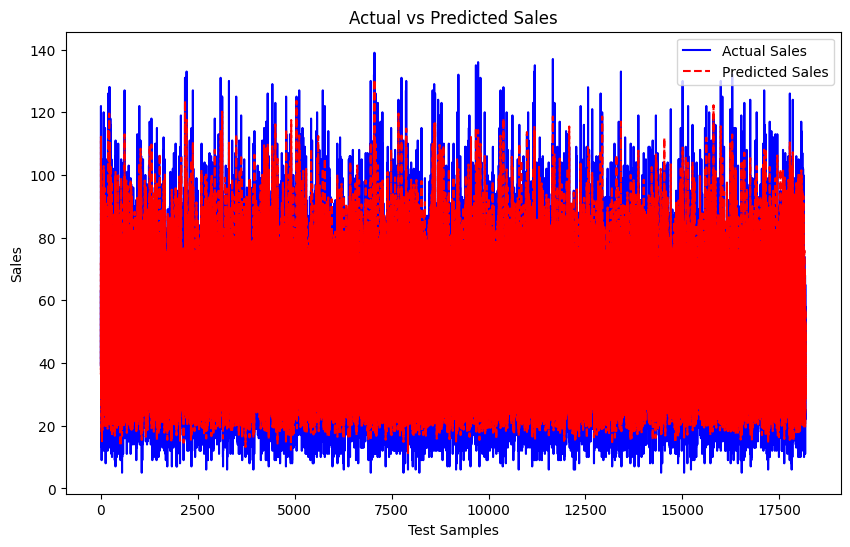

In [10]:
# Visualize predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales', color='blue')
plt.plot(y_pred, label='Predicted Sales', color='red', linestyle='--')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Test Samples')
plt.ylabel('Sales')
plt.legend()
plt.show()